In [1]:
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets

     |████████████████████████████████| 89 kB 2.3 MB/s 
     |████████████████████████████████| 4.7 MB 11.8 MB/s 


In [2]:
import os
import pprint
import tempfile

from typing import Dict, Text

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

%matplotlib inline
import matplotlib.pyplot as plt


### Loading the MovieLens dataset

In [3]:
ratings = tfds.load("movielens/100k-ratings", split="train")
movies = tfds.load("movielens/100k-movies", split="train")

ratings = ratings.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"],
    "user_rating": x["user_rating"]
})
movies = movies.map(lambda x: x["movie_title"])

tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

movie_titles = ratings.batch(1_000_000).map(lambda x: x["movie_title"])
user_ids = ratings.batch(1_000_000).map(lambda x: x["user_id"])

unique_movie_titles = np.unique(np.concatenate(list(movie_titles)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/100000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/movielens/100k-ratings/0.1.1.incomplete862AO9/movielens-train.tfrecord*...…

Dataset movielens downloaded and prepared to /root/tensorflow_datasets/movielens/100k-ratings/0.1.1. Subsequent calls will reuse this data.


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1682 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/movielens/100k-movies/0.1.1.incompleteSFT9N1/movielens-train.tfrecord*...:…

Dataset movielens downloaded and prepared to /root/tensorflow_datasets/movielens/100k-movies/0.1.1. Subsequent calls will reuse this data.


### Ranking Model definition

In [4]:
class UserModel(tf.keras.Model):
  
  def __init__(self):
    super().__init__()

    self.user_embedding = tf.keras.Sequential([
        tf.keras.layers.StringLookup(
            vocabulary=unique_user_ids, mask_token=None),
        tf.keras.layers.Embedding(len(unique_user_ids) + 1, 32),
    ])

  def call(self, inputs):
    return tf.concat([
        self.user_embedding(inputs["user_id"]),
    ], axis=1)

In [5]:
class MovieModel(tf.keras.Model):
  
  def __init__(self):
    super().__init__()

    max_tokens = 10_000

    self.title_embedding = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
          vocabulary=unique_movie_titles,mask_token=None),
      tf.keras.layers.Embedding(len(unique_movie_titles) + 1, 32)
    ])

    self.title_vectorizer = tf.keras.layers.TextVectorization(
        max_tokens=max_tokens)

    self.title_text_embedding = tf.keras.Sequential([
      self.title_vectorizer,
      tf.keras.layers.Embedding(max_tokens, 32, mask_zero=True),
      tf.keras.layers.GlobalAveragePooling1D(),
    ])

    self.title_vectorizer.adapt(movies)

  def call(self, titles):
    return tf.concat([
        self.title_embedding(titles),
        self.title_text_embedding(titles),
    ], axis=1)

In [6]:
class RankingModel(tf.keras.Model):

  def __init__(self, layer_sizes):
    super().__init__()
    embedding_dimension = 32

    # Compute embeddings for users.
    self.user_embeddings = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_user_ids, mask_token=None),
      tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
    ])

    # Compute embeddings for movies.
    self.movie_embeddings = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_movie_titles, mask_token=None),
      tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
    ])

    # Compute predictions.
    self.ratings = tf.keras.Sequential()

    for layer_size in layer_sizes[:-1]:
      self.ratings.add(tf.keras.layers.Dense(layer_size, activation="relu"))
    
    self.ratings.add(tf.keras.layers.Dense(1))
    
    
  def call(self, inputs):

    user_id, movie_title = inputs
    user_embedding = self.user_embeddings(user_id)
    movie_embedding = self.movie_embeddings(movie_title)

    return self.ratings(tf.concat([user_embedding, movie_embedding], axis=1))

In [7]:
class MovielensModel(tfrs.models.Model):

  def __init__(self, layer_sizes):
    super().__init__()
    self.ranking_model: tf.keras.Model = RankingModel(layer_sizes)
    self.task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
      loss = tf.keras.losses.MeanSquaredError(),
      metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )

  def call(self, features: Dict[str, tf.Tensor]) -> tf.Tensor:
    return self.ranking_model(
        (features["user_id"], features["movie_title"]))

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
    labels = features.pop("user_rating")
    
    rating_predictions = self(features)

    # The task computes the loss and the metrics.
    return self.task(labels=labels, predictions=rating_predictions)

# Experiments

In [9]:
cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

#### 1.Single Layer Model

In [13]:
num_epochs = 300

model = MovielensModel([64])
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.01))

one_layer_history = model.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=5,
    epochs=num_epochs,
    verbose=0)

accuracy = one_layer_history.history["root_mean_squared_error"][-1]
print(f"RMSE: {accuracy:.2f}")

RMSE: 0.97


#### 2.Two Layer Model

In [14]:
model = MovielensModel([256,64])
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.01))

two_layer_history = model.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=5,
    epochs=num_epochs,
    verbose=0)

accuracy = two_layer_history.history["root_mean_squared_error"][-1]
print(f"RMSE: {accuracy:.2f}")

RMSE: 0.92


#### 3.Three Layer Model

In [15]:
model = MovielensModel([1024,256, 64])
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

three_layer_history = model.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=5,
    epochs=num_epochs,
    verbose=0)

accuracy = three_layer_history.history["root_mean_squared_error"][-1]
print(f"RMSE: {accuracy:.2f}")

RMSE: 0.80


#### 4.Four Layer Model

In [16]:
model = MovielensModel([2048,1024,256, 64])
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

four_layer_history = model.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=5,
    epochs=num_epochs,
    verbose=0)

accuracy = four_layer_history.history["root_mean_squared_error"][-1]
print(f"RMSE: {accuracy:.2f}")

RMSE: 0.76


## Results

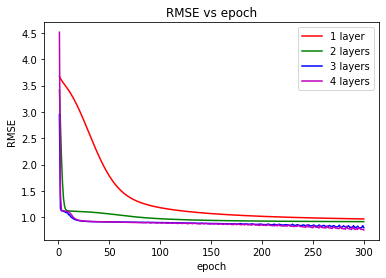

In [17]:
num_validation_runs = len(one_layer_history.history["root_mean_squared_error"])
epochs = [(x + 1) for x in range(num_validation_runs)]

plt.plot(epochs, one_layer_history.history["root_mean_squared_error"], label="1 layer",c='r')
plt.plot(epochs, two_layer_history.history["root_mean_squared_error"], label="2 layers",c='g')
plt.plot(epochs, three_layer_history.history["root_mean_squared_error"], label="3 layers",c='b')
plt.plot(epochs, four_layer_history.history["root_mean_squared_error"], label="4 layers",c='m')
plt.title("RMSE vs epoch")
plt.xlabel("epoch")
plt.ylabel("RMSE");
plt.legend()

As we can see from the grpah, after 3 layers there is very minimal improvemnt in rmse score and increasing layers is not beneficial anymore. 